In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
import sys

# Specify the path to the 'src' directory within your Google Drive
path_to_src = '/content/drive/My Drive/465 Project'

# Add the 'src' directory to sys.path
if path_to_src not in sys.path:
    sys.path.append(path_to_src)

# Now you can import your modules
import src.utils as utils
from src.dataloader import DatasetSegmentation, collate_fn
from src.processor import Samprocessor
from src.segment_anything import build_sam_vit_b, SamPredictor
from src.lora import LoRA_sam

In [2]:
# Test imports
try:
    import src.utils as utils
    from src.dataloader import DatasetSegmentation, collate_fn
    from src.processor import Samprocessor
    from src.segment_anything import build_sam_vit_b, SamPredictor
    from src.lora import LoRA_sam

    print("Successfully imported all modules.")

    # Optionally, you can test specific functions or classes to see if they work
    print("Testing function availability:")
    print("utils function:", hasattr(utils, 'get_bounding_box'))  # Example function name in utils
    print("DatasetSegmentation available:", 'DatasetSegmentation' in dir())

    print("Samprocessor available:", 'Samprocessor' in dir())

except ImportError as e:
    print("An error occurred while importing:", e)

Successfully imported all modules.
Testing function availability:
utils function: True
DatasetSegmentation available: True
Samprocessor available: True


In [3]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00


In [4]:
import torch
import monai
from tqdm import tqdm
from statistics import mean
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.nn.functional import threshold, normalize
from torchvision.utils import save_image
# import src.utils as utils
# from src.dataloader import DatasetSegmentation, collate_fn
# from src.processor import Samprocessor
# from src.segment_anything import build_sam_vit_b, SamPredictor
# from src.lora import LoRA_sam
import matplotlib.pyplot as plt
import yaml
import torch.nn.functional as F

In [5]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

imports

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_COUNT = 480

In [7]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

In [ ]:
# # extract data from zip file
# import zipfile
# import os

# # Define the path to your zip file and the directory where you want to extract it
# zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
# extract_folder_path = '/content/drive/MyDrive/465 Project/Dataset'

# os.makedirs(extract_folder_path, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

In [8]:
import os
import glob
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Specify directories
image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RG'
mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RGMask'
temp_train_image_dir = '/content/train/images'
temp_train_mask_dir = '/content/train/masks'
temp_test_image_dir = '/content/test/images'
temp_test_mask_dir = '/content/test/masks'

# Ensure the temporary directories exist
os.makedirs(temp_train_image_dir, exist_ok=True)
os.makedirs(temp_train_mask_dir, exist_ok=True)
os.makedirs(temp_test_image_dir, exist_ok=True)
os.makedirs(temp_test_mask_dir, exist_ok=True)

# Load all file names
image_files = sorted(glob.glob(os.path.join(image_dir, '*')))
mask_files = [os.path.join(mask_dir, 'RGMask' + os.path.basename(img)[2:]) for img in image_files]

# Shuffle data with a fixed random seed for reproducibility
random_state = 42
shuffled_indices = np.random.RandomState(seed=random_state).permutation(len(image_files))
image_files = np.array(image_files)[shuffled_indices]
mask_files = np.array(mask_files)[shuffled_indices]

# Split data (85% train, 10% test, 5% unused or can be used as validation)
train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.15, train_size=0.85, random_state=random_state)

# Store the split data into temporary directories
cnt = 0;
for img_file, mask_file in zip(train_images, train_masks):
    # if cnt == 50:
      # break
    shutil.copy(img_file, temp_train_image_dir)
    shutil.copy(mask_file, temp_train_mask_dir)
    cnt+=1
cnt = 0;
for img_file, mask_file in zip(test_images, test_masks):
    # if cnt == 8:
      # break
    shutil.copy(img_file, temp_test_image_dir)
    shutil.copy(mask_file, temp_test_mask_dir)
    cnt+=1

# Store the directory paths in variables
train_image_path = temp_train_image_dir
train_mask_path = temp_train_mask_dir
test_image_path = temp_test_image_dir
test_mask_path = temp_test_mask_dir

print("Training images stored in:", train_image_path)
print("Training masks stored in:", train_mask_path)
print("Testing images stored in:", test_image_path)
print("Testing masks stored in:", test_mask_path)

Training images stored in: /content/train/images
Training masks stored in: /content/train/masks
Testing images stored in: /content/test/images
Testing masks stored in: /content/test/masks


In [18]:
sam = build_sam_vit_b(checkpoint="/content/drive/My Drive/465 Project/sam_vit_b_01ec64.pth")

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_lora = LoRA_sam(sam, 512)
model = sam_lora.sam
model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): LoRA_qkv(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (linear_a_q): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_q): Linear(in_features=512, out_features=768, bias=False)
            (linear_a_v): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_v): Linear(in_features=512, out_features=768, bias=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linea

In [20]:
# Initialize the processor
from src.processor import Samprocessor
processor = Samprocessor(model)

# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [21]:
import torch
import glob
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

from src.processor import Samprocessor
from src.segment_anything import build_sam_vit_b, SamPredictor
from src.lora import LoRA_sam
import src.utils as utils
import yaml

from PIL import Image
import torch
import numpy as np

class DatasetSegmentation(Dataset):
    """
    Dataset to process the images and masks.
    Arguments:
        image_dir (str): Directory path containing the images.
        mask_dir (str): Directory path containing the masks.
        processor (obj): Samprocessor instance for preprocessing images and prompts.
        mode (str): Mode of dataset usage either 'train' or 'test'.
    Returns:
        dict: Dictionary with keys: image, original_size, boxes, ground_truth_mask, image_path, mask_path.
    """
    def __init__(self, image_dir: str, mask_dir: str, processor: Samprocessor, mode: str):
        super().__init__()
        self.image_files = sorted(glob.glob(os.path.join(image_dir, "*")))
        self.mask_files = [os.path.join(mask_dir, 'RGMask' + os.path.basename(img)[2:]) for img in self.image_files]
        self.processor = processor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index: int) -> dict:
        img_path = self.image_files[index]
        mask_path = self.mask_files[index]
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB
        mask = Image.open(mask_path).convert('1')  # Ensure mask is binary
        # print(image.size)
        # print(mask.size)
        image = image.resize((256, 256), Image.Resampling.LANCZOS)
        mask = mask.resize((256, 256), Image.Resampling.LANCZOS)
        # print(image.size)
        # print(mask.size)

        ground_truth_mask = np.array(mask)
        original_size = image.size[::-1]  # Reverse the size tuple to match height, width

        box = utils.get_bounding_box(ground_truth_mask)
        inputs = self.processor(image, original_size, box)
        inputs['ground_truth_mask'] = torch.from_numpy(ground_truth_mask)
        inputs['image_path'] = img_path  # Store image path
        inputs['mask_path'] = mask_path  # Store mask path

        return inputs


training_dataset= DatasetSegmentation(temp_train_image_dir, temp_train_mask_dir, processor, mode='train')
testing_dataset= DatasetSegmentation(temp_test_image_dir, temp_test_mask_dir, processor, mode='test')

In [ ]:
testing_dataset[0]

{'image': tensor([[[[ 42,  42,  55,  ...,   6,   6,   6],
           [ 42,  42,  55,  ...,   6,   6,   6],
           [ 43,  43,  56,  ...,   6,   6,   6],
           ...,
           [ 17,  17,  19,  ..., 124, 122, 122],
           [ 15,  15,  17,  ..., 125, 123, 123],
           [ 15,  15,  17,  ..., 125, 123, 123]],
 
          [[ 19,  19,  32,  ...,  10,  10,  10],
           [ 19,  19,  32,  ...,  10,  10,  10],
           [ 20,  20,  33,  ...,  10,  10,  10],
           ...,
           [ 14,  14,  16,  ..., 106, 105, 105],
           [ 12,  12,  14,  ..., 107, 105, 105],
           [ 12,  12,  14,  ..., 107, 105, 105]],
 
          [[ 17,  17,  29,  ...,   0,   0,   0],
           [ 17,  17,  29,  ...,   0,   0,   0],
           [ 17,  17,  30,  ...,   0,   0,   0],
           ...,
           [ 20,  20,  21,  ...,  99,  98,  98],
           [ 18,  18,  20,  ..., 100,  98,  98],
           [ 18,  18,  20,  ..., 100,  98,  98]]]], device='cuda:0',
        dtype=torch.uint8),
 'origi

In [ ]:
# Create an instance of the SAMDataset
# dataset = DatasetSegmentation(image_dir, mask_dir, processor, mode='train')

# train_dataset = SAMDataset(dataset=train_dataset_, processor=processor)
# val_dataset = SAMDataset(dataset=val_dataset_, processor=processor)
# test_dataset = SAMDataset(dataset=test_dataset_, processor=processor)


In [ ]:
# from torch.utils.data import random_split

# # Calculate split sizes
# total_size = len(dataset)
# train_size = int(0.80 * total_size)
# remaining_size = total_size - train_size
# val_size = int(0.5 * remaining_size)
# test_size = remaining_size - val_size

# # Split the dataset
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# # Assuming 'images' and 'masks' are your preloaded lists of numpy arrays
# train_images = [images[i] for i in train_dataset_.indices]
# train_masks = [masks[i] for i in train_dataset_.indices]
# val_images = [images[i] for i in val_dataset_.indices]
# val_masks = [masks[i] for i in val_dataset_.indices]
# test_images = [images[i] for i in test_dataset_.indices]
# test_masks = [masks[i] for i in test_dataset_.indices]

# train_dataset = DatasetSegmentation(train_images, train_masks, processor)
# val_dataset = DatasetSegmentation(val_images, val_masks, processor)
# test_dataset = DatasetSegmentation(test_images, test_masks, processor)


In [ ]:
# # Create a DataLoader instance for the training dataset
# from torch.utils.data import DataLoader
# # train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
# val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [22]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=0.0001, weight_decay=0)
# Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [23]:
train_dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=True,collate_fn=collate_fn)

In [24]:
# Function to test a single index
def test_single_index(dataset, idx):
    try:
        result = dataset[idx]
        print(f"Test at index {idx} passed.")
        # print("Result:", result)
    except Exception as e:
        print(f"Test at index {idx} failed with error: {e}")

# Test multiple indices
for i in range(len(training_dataset)):
    test_single_index(training_dataset, i)
    break


Test at index 0 passed.


In [25]:
from tqdm import tqdm
from statistics import mean
import torch

# Training loop
num_epochs = 15
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

total_loss = []

for epoch in range(num_epochs):
    epoch_losses = []

    for i, batch in enumerate(tqdm(train_dataloader)):

      outputs = model(batched_input=batch,
                      multimask_output=False)

      stk_gt, stk_out = utils.stacking_batch(batch, outputs)
      stk_out = stk_out.squeeze(1)
      stk_gt = stk_gt.unsqueeze(1) # We need to get the [B, C, H, W] starting from [H, W]
      loss = seg_loss(stk_out, stk_gt.float().to(device))

      optimizer.zero_grad()
      loss.backward()
      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss training: {mean(epoch_losses)}')

100%|██████████| 408/408 [07:47<00:00,  1.15s/it]


EPOCH: 0
Mean loss training: 0.41075757248144523


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 1
Mean loss training: 0.386741692675095


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 2
Mean loss training: 0.38134025051897646


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 3
Mean loss training: 0.3778231001513846


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]


EPOCH: 4
Mean loss training: 0.3759894579210702


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 5
Mean loss training: 0.37400707354148227


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 6
Mean loss training: 0.3727695707450895


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]


EPOCH: 7
Mean loss training: 0.37064897641539574


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]


EPOCH: 8
Mean loss training: 0.3694557557795562


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 9
Mean loss training: 0.36825550720095634


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 10
Mean loss training: 0.36816783081374915


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]


EPOCH: 11
Mean loss training: 0.36614620634445955


100%|██████████| 408/408 [07:48<00:00,  1.15s/it]


EPOCH: 12
Mean loss training: 0.3652358988628668


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]


EPOCH: 13
Mean loss training: 0.36317964672457936


100%|██████████| 408/408 [07:49<00:00,  1.15s/it]

EPOCH: 14
Mean loss training: 0.3614549215736927


In [26]:
torch.save(model.state_dict(), "/content/drive/MyDrive/465 Project/SAM LORA/15_epoch_408_img_lora_rank512pytorch.pth")

In [40]:
sam = build_sam_vit_b(checkpoint="/content/drive/My Drive/465 Project/sam_vit_b_01ec64.pth")

In [41]:
sam_lora = LoRA_sam(sam, 512)
model = sam_lora.sam

In [45]:
model.load_state_dict(torch.load("/content/drive/MyDrive/465 Project/SAM LORA/15_epoch_408_img_lora_rank512pytorch.pth"))

<All keys matched successfully>

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): LoRA_qkv(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (linear_a_q): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_q): Linear(in_features=512, out_features=768, bias=False)
            (linear_a_v): Linear(in_features=768, out_features=512, bias=False)
            (linear_b_v): Linear(in_features=512, out_features=768, bias=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linea

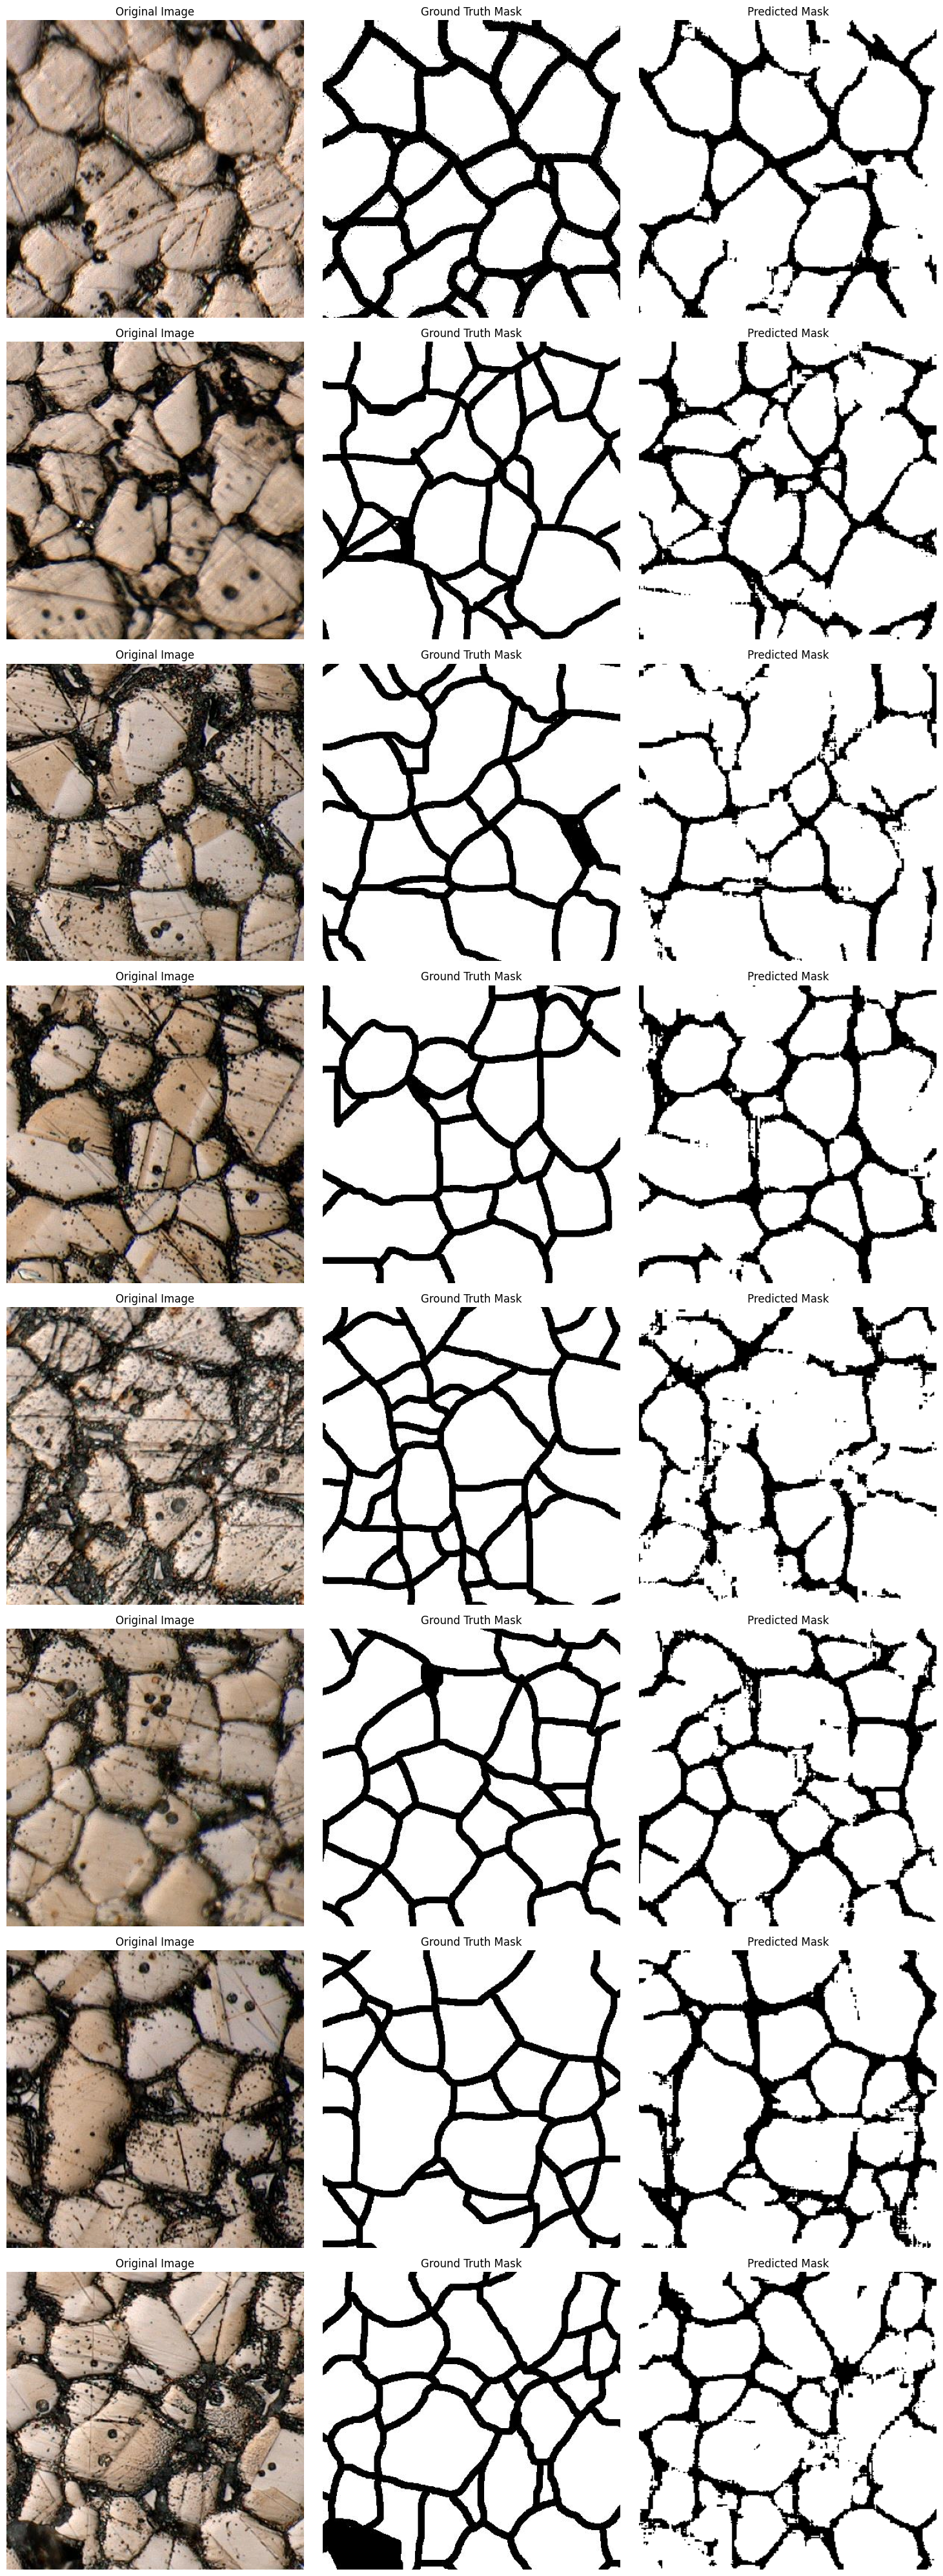

In [47]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def plot_images(images, masks, predicted_masks, num_images=5):
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(min(num_images, len(images))):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(Image.open(images[i]))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(Image.open(masks[i]), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 3)
        pred_mask = predicted_masks[i].squeeze().cpu().numpy()  # Assuming mask prediction is a torch tensor
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage inside your test loop
num_images_to_display = 8
images_to_display = []
masks_to_display = []
preds_to_display = []

model.eval()
with torch.no_grad():
  for i, batch in enumerate(test_dataloader):
      if i >= num_images_to_display:
          break
      outputs = model(batched_input=batch,
                  multimask_output=False)
      predicted_masks = outputs[0]['masks']

      images_to_display.append(batch[0]['image_path'])  # Ensure you have path or adjust accordingly
      masks_to_display.append(batch[0]['mask_path'])    # Ensure you have path or adjust accordingly
      preds_to_display.append(predicted_masks)

  plot_images(images_to_display, masks_to_display, preds_to_display, num_images_to_display)


In [28]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.1 MB/s eta 0:00:00


In [48]:
from torchmetrics.functional import dice

# Assuming test_dataloader is already created and model is loaded
total_dice_score = 0.0
total_num_samples = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# Ensure the model is in evaluation mode
model.eval()
cnt = 0

# Loop over the test dataset
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader)):
        cnt+=1
        # Forward pass

        outputs = model(batched_input=batch,
                        multimask_output=False)
        predicted_masks = outputs[0]['masks']

        ground_truth_masks = batch[0]["ground_truth_mask"].unsqueeze(0).unsqueeze(0) # We need to get the [B, C, H, W] starting from [H, W]

        # Move tensors to the same device
        predicted_masks = predicted_masks.to(device)
        ground_truth_masks = ground_truth_masks.to(device)
        predicted_masks = predicted_masks.to(torch.int64)
        ground_truth_masks = ground_truth_masks.to(torch.int64)
        for ind in range(len(predicted_masks)):
            pred_tensor = (predicted_masks[ind] > 0.5).float()
            gt_tensor = ground_truth_masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

    # Compute the final Dice score
    total_num_samples = cnt*1 # cnt*batch size
    print(f"Final Dice score on test set: {cnt}")
    average_dice_score = total_dice_score / total_num_samples

    print(f"Final Dice score on test set: {average_dice_score}")


100%|██████████| 72/72 [00:36<00:00,  1.95it/s]

Final Dice score on test set: 72
Final Dice score on test set: 0.9093425431185298
